# Visualisation of the Prediction Depth of CIFAR-10

### - Read output from `get_pd`

In [1]:
import os
import json

def read_pd_files(directory: str) -> tuple[list[str], list[dict]]:
    """
    This function is going to read all .pkl file from a give directory
    @param directory: ..
    @return: ([file name list], [dict list])
    """
    pd_dict_list = []
    file_list = os.listdir(directory)
    pkl_files = [file for file in file_list if file.endswith(".pkl")]

    for pkl_file in pkl_files:
        file_path = os.path.join(directory, pkl_file)
        with open(file_path, "rb") as f:
            dict_load = json.load(f)

            for i in dict_load.keys():
                dict_load[i] = dict_load[i][0] # list of 1 int -> int

            pd_dict_list.append(dict_load)

    return pkl_files, pd_dict_list


pd_result_dir = os.path.join(os.getcwd(), "cl_results_vgg") # change the second argument to specify the result file
file_name_list, pd_dicts = read_pd_files(pd_result_dir)
number_of_pd_result = len(pd_dicts)
pd_avg_dict = {}

# calculate the average of all pd_dict
for pd_dict in pd_dicts:
    for i in pd_dict.keys():
        pd_avg_dict[int(i)] = pd_avg_dict.get(int(i)) + pd_dict[i] if (int(i) in pd_avg_dict.keys()) else pd_dict[i]
for i in pd_avg_dict:
    pd_avg_dict[i] = round((pd_avg_dict[i])/number_of_pd_result)

### - Link `pd_dict` with CIFAR dataset

In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor
import matplotlib.pyplot as plt

class CIFAR10PD(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CIFAR10PD, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index):
        # to get (img, target), index
        img, target = super(CIFAR10PD, self).__getitem__(index)
        return PILToTensor()(img), target, index
trainset = CIFAR10PD('./', train=False, download=True)
testset = CIFAR10PD('./', train=True, download=True)

dataloader_train = DataLoader(trainset, batch_size=1, shuffle=False)
dataloader_test = DataLoader(testset, batch_size=1, shuffle=False)

CIFAR_dict = {}

for imgs, targets, indexes in dataloader_train:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict[index.item()] = (img, target)
for imgs, targets, indexes in dataloader_test:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict[index.item()] = (img, target)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# image_np = CIFAR_dict[1198][0].numpy()
# image_np = image_np.transpose(1, 2, 0)
#
# # Plot the CIFAR-10 image
# plt.imshow(image_np)
# plt.axis('off')
# plt.show()

In [4]:
def imgPDLink(img_dict: dict, pd_dict:dict) -> dict:
    """
    This function gives each image its Prediction Depth score
    @param img_dict: dictionary of image in the format of {index : (img, target)}
    @param pd_dict: dictionary of image in the format of {index : PD score}
    @return: dictionary of {img : (target, PD score)}
    """

    imgPD_dict = {}
    for index in pd_dict.keys():
        imgPD_dict[img_dict[index][0]] = (img_dict[index][1], pd_dict[index], index)
    return imgPD_dict

imgPD_dict = imgPDLink(CIFAR_dict, pd_avg_dict)

### - Visualization

Max score: 6, Min score: 0
Score: 1


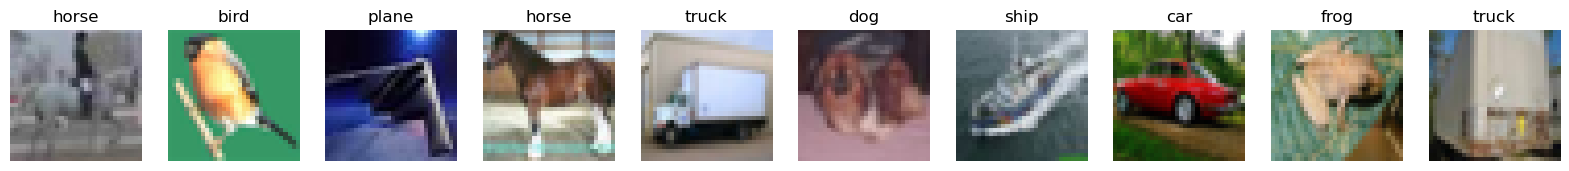

Score: 2


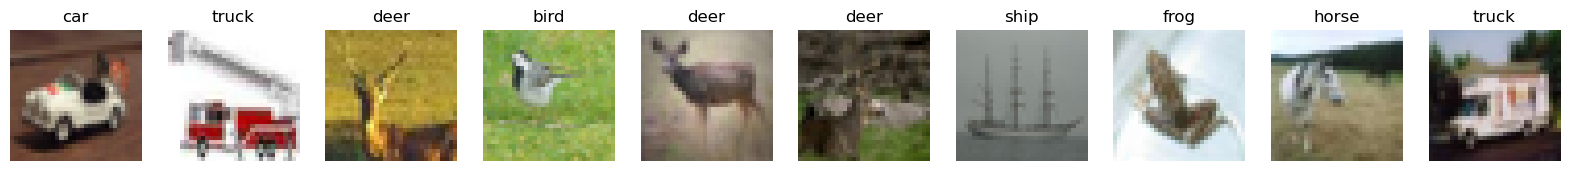

Score: 3


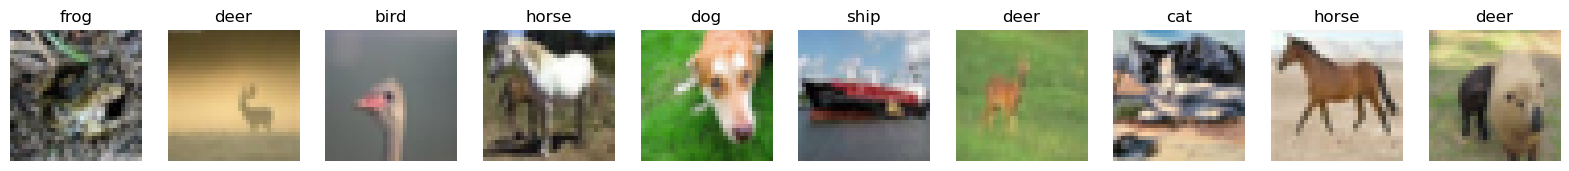

Score: 4


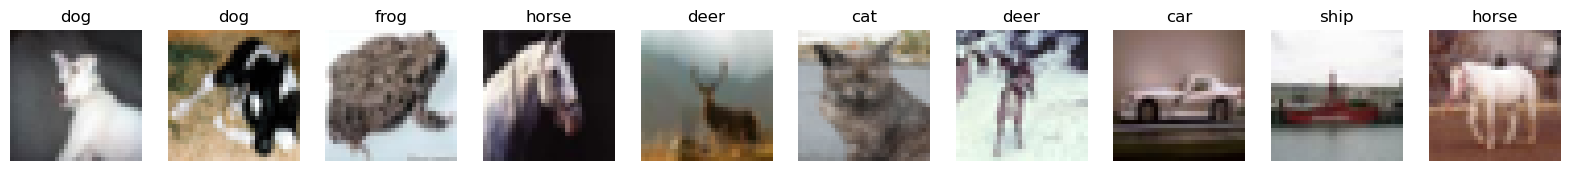

Score: 5


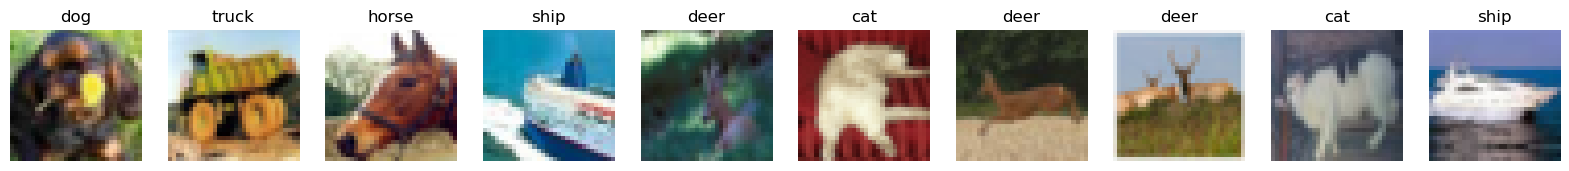

Score: 6


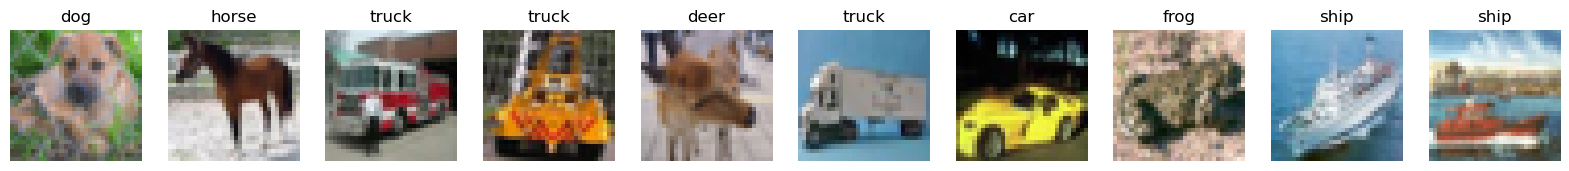

Score: 7


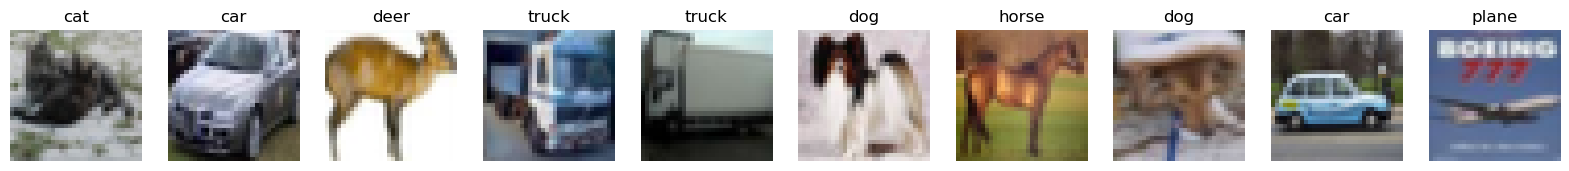

In [6]:
# Visualisation of the Prediction Depth of CIFAR-10, we grab 10 images for each score
max_score, min_score = max(imgPD_dict.values(), key=lambda x: x[1])[1], min(imgPD_dict.values(), key=lambda x: x[1])[1]
print(f"Max score: {max_score}, Min score: {min_score}")
images_per_score = [[] for _ in range(max_score + 1)]
for img, (target, score, index) in imgPD_dict.items():
    images_per_score[score].append((img, target, index)) if len(images_per_score[score]) < 10 else None


target_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for score, images in enumerate(images_per_score):
    if len(images) == 0:
        continue
    print(f"Score: {score+1}")
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (img, target, index) in enumerate(images):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(target_names[target])
        axes[i].axis('off')
    plt.show()